<a href="https://colab.research.google.com/github/dk-tran92/ML/blob/main/Nhan_dang_mau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pyro-ppl

     |████████████████████████████████| 713 kB 5.3 MB/s 


In [5]:
import time         # We will time our execution often

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (442, 10)
Target shape is (442,)


In [56]:
diabetes.data[0]

array([ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
       -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613])

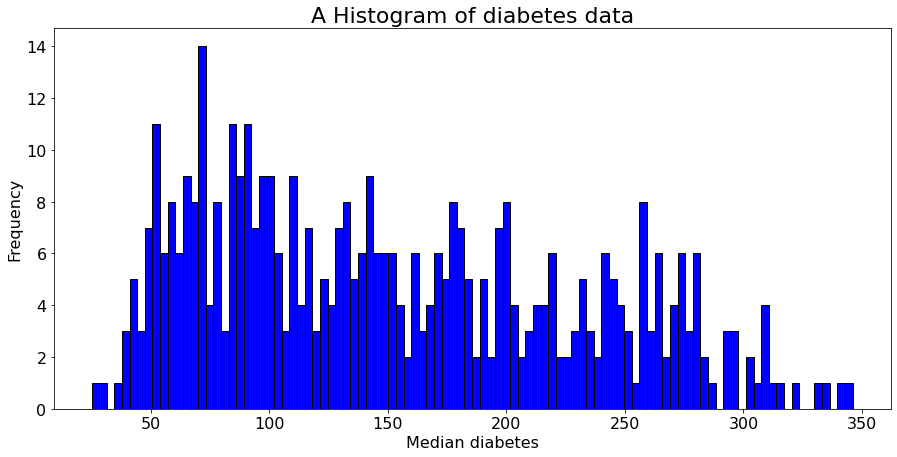

In [6]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median diabetes", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of diabetes data", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [31]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(353, 10) (353,)
(89, 10) (89,)


In [8]:
# start timing
start_time = time.time()

# fit linear regression
my_linear_regression = LinearRegression().fit(X_train,y_train)
y_pred = my_linear_regression.predict(X_test)

end_time = time.time()

# print point estimates of the coefficients
print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(diabetes.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

beta_intercept: 150.65
beta_age: -26.91
beta_sex: -232.65
beta_bmi: 557.51
beta_bp: 320.3
beta_s1: -746.6
beta_s2: 403.4
beta_s3: 139.75
beta_s4: 339.51
beta_s5: 652.77
beta_s6: 12.51


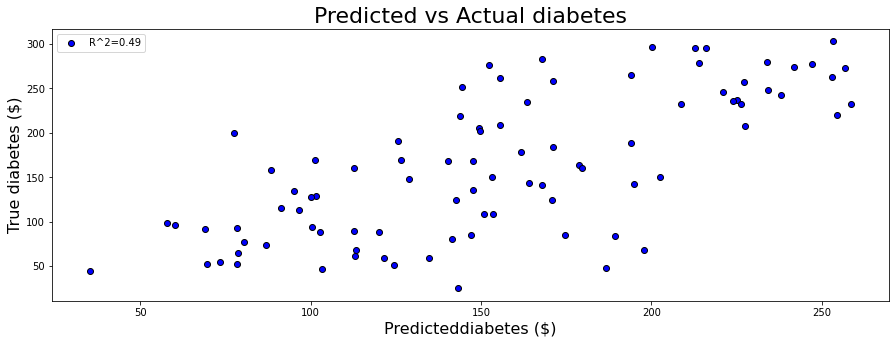

In [9]:
def plot_all_observations(y_true, y_pred, y_max):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted vs Actual diabetes", size=22)
    plt.xlabel("Predicted diabetes ($)", size=16)
    plt.ylabel("True diabetes ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
y_censor_label = y_train.max()
plot_all_observations(y_test, y_pred, y_censor_label)

# Bayesion Linear Regression with Pyro


In [40]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

In [13]:
def model_normal(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [14]:
SAMPLE_NUMBER = 353


# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then discard the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=53)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             diabetes.feature_names)

end_time = time.time()

print()
print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 406/406 [01:32,  4.39it/s, step size=1.70e-01, acc. prob=0.949]


Inference ran for 1.54 minutes


In [15]:
my_mcmc1.summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
        beta_age     -0.04      1.01     -0.06     -1.37      1.75    408.87      1.00
        beta_bmi      0.03      1.02      0.00     -1.84      1.44    422.37      1.00
         beta_bp      0.14      1.04      0.16     -1.59      1.74    378.06      1.00
  beta_intercept      2.94      0.98      2.92      1.42      4.68    565.14      1.00
         beta_s1      0.06      0.95      0.08     -1.41      1.58    290.42      1.01
         beta_s2     -0.04      0.99     -0.08     -1.50      1.62    318.98      1.01
         beta_s3     -0.03      1.05      0.02     -1.57      1.80    304.13      1.00
         beta_s4      0.09      1.02      0.15     -1.42      1.72    210.37      1.00
         beta_s5      0.04      1.03     -0.00     -1.51      1.88    377.64      1.00
         beta_s6      0.05      1.06      0.01     -1.45      1.97    306.89      1.00
        beta_sex     -0.03      0.96      

In [16]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df.head()

,beta_age,beta_bmi,beta_bp,beta_intercept,beta_s1,beta_s2,beta_s3,beta_s4,beta_s5,beta_s6,beta_sex,sigma
0,0.170870,-0.488107,0.732503,2.181939,-1.458596,-1.372523,0.567455,-0.800505,2.483900,-0.223791,-0.083827,131.505605
1,-0.231592,0.008544,-1.288192,2.305494,1.449012,0.807718,-1.057353,0.151198,-2.410606,0.824519,0.097539,139.421348
2,-0.597462,0.220904,-0.652130,3.497960,0.854171,1.507239,0.326182,0.947456,0.660000,-0.881721,-0.207715,135.646133
3,-0.100470,1.252952,0.731957,3.395435,-0.950472,-1.362360,-0.755234,-0.400517,-0.981582,1.351853,-0.272239,133.381056
4,1.373418,-1.541007,1.090566,2.199362,0.931695,-0.944220,-0.148456,-0.803071,-0.017177,1.724092,-0.265223,138.594732


In [17]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [18]:
linear_combination = predict_linear_combination(beta_df, X_test)
# Our predictions are the linear combination
y_pred = linear_combination

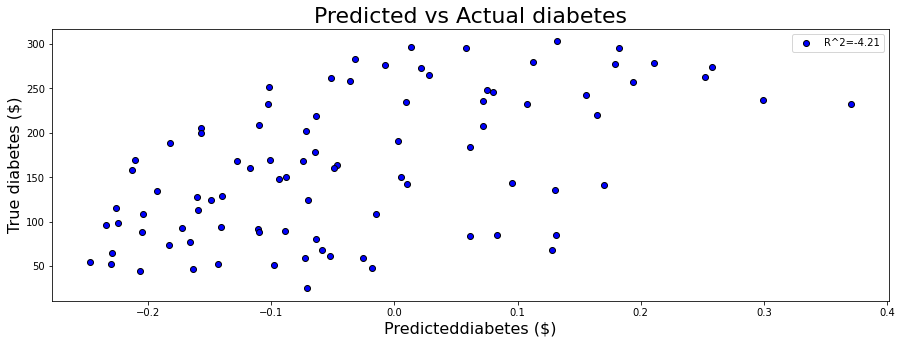

In [19]:
plot_all_observations(y_test, y_pred, y_censor_label)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

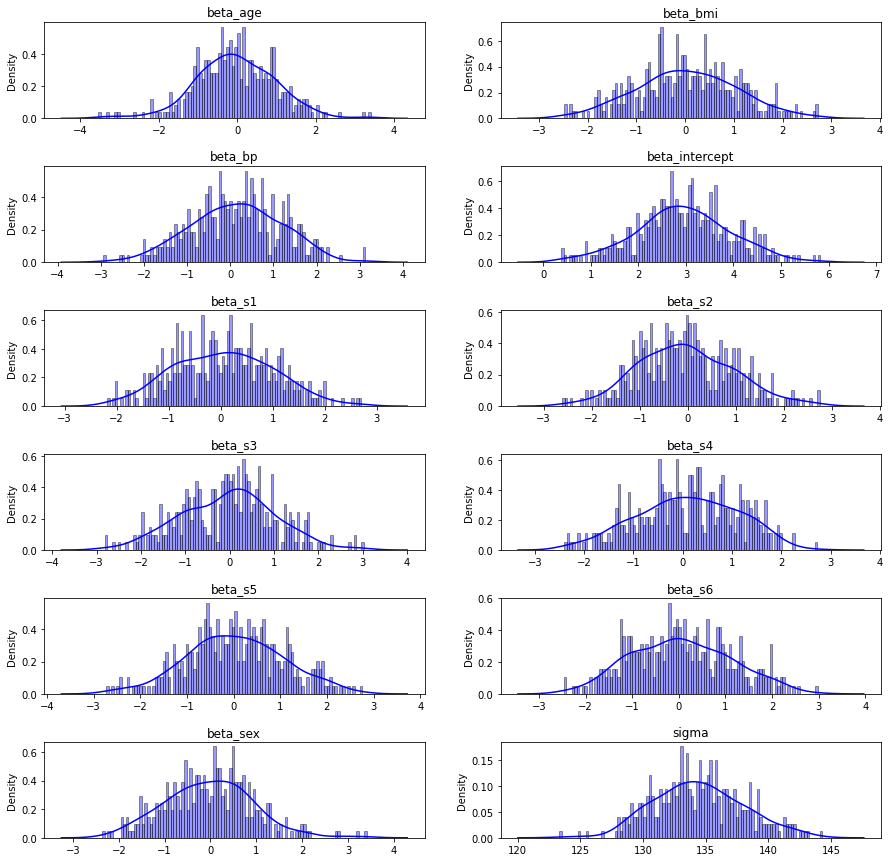

In [21]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(6,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_coefficients(beta_df)

In [57]:
def model_normal_V(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        if column_names[i] != 'sex':
            coefficient_prior = dist.Normal(0.0, 1.0)
            beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
            linear_combination = linear_combination + (X[:, i] * beta_coef)
        else:
            sex_index = i

    coefficient_sex_prior = dist.HalfNormal(scale=5.0)
    beta_sex_coef = pyro.sample(f"beta_sex", coefficient_sex_prior)
    linear_combination = linear_combination + (X[:, sex_index] * beta_sex_coef)


    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

Warmup:   0%|          | 0/406 [04:24, ?it/s]


In [58]:
SAMPLE_NUMBER = 353


# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel2 = NUTS(model_normal_V, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then discard the first 100
my_mcmc2 = MCMC(my_kernel2,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=53)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc2.run(X_train_torch, 
             y_train_torch,
             diabetes.feature_names)

end_time = time.time()

print()
print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 406/406 [01:36,  4.22it/s, step size=1.37e-01, acc. prob=0.801]


Inference ran for 1.6 minutes


In [60]:
my_mcmc2.summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
        beta_age      0.11      0.95      0.10     -1.40      1.59    553.15      1.00
        beta_bmi      0.02      1.02      0.01     -1.92      1.46    598.83      1.00
         beta_bp      0.05      1.03     -0.01     -1.51      1.71    388.08      1.00
  beta_intercept      2.84      1.04      2.83      1.18      4.60    485.10      1.00
         beta_s1      0.03      1.11      0.00     -1.55      1.94    541.23      1.00
         beta_s2     -0.00      0.97      0.08     -1.74      1.31    435.66      1.00
         beta_s3     -0.02      0.95      0.04     -1.38      1.63    319.82      1.00
         beta_s4      0.05      1.19      0.08     -1.70      2.23    448.76      1.00
         beta_s5      0.10      0.99      0.13     -1.56      1.63    450.77      1.00
         beta_s6      0.09      1.14      0.04     -1.58      2.01    249.96      1.00
        beta_sex      4.04      2.88      

In [62]:
beta_df = pd.DataFrame(my_mcmc2.get_samples())
beta_df.head()

,beta_age,beta_bmi,beta_bp,beta_intercept,beta_s1,beta_s2,beta_s3,beta_s4,beta_s5,beta_s6,beta_sex,sigma
0,1.734892,0.387115,-0.918832,2.912430,-0.712659,-2.003962,0.838891,0.269689,0.769474,-0.142908,0.116937,136.200696
1,-1.035444,0.665764,-0.153197,2.668672,-0.552305,-2.790078,0.188894,0.670418,0.525176,0.823318,0.039719,140.161381
2,-0.238736,1.640758,-0.051309,2.373938,-1.277258,-3.146287,-0.481625,2.068721,1.083730,-0.224042,0.043258,137.148348
3,1.354157,-1.912238,-0.039941,1.663251,1.260511,3.169454,-0.345149,-0.704974,-2.034338,1.862512,0.662198,135.697028
4,0.416393,-0.881675,-0.799188,1.636354,0.296847,1.041926,0.801697,0.581680,-0.325315,1.715454,1.096413,142.134198


In [63]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [64]:
linear_combination = predict_linear_combination(beta_df, X_test)
# Our predictions are the linear combination
y_pred = linear_combination

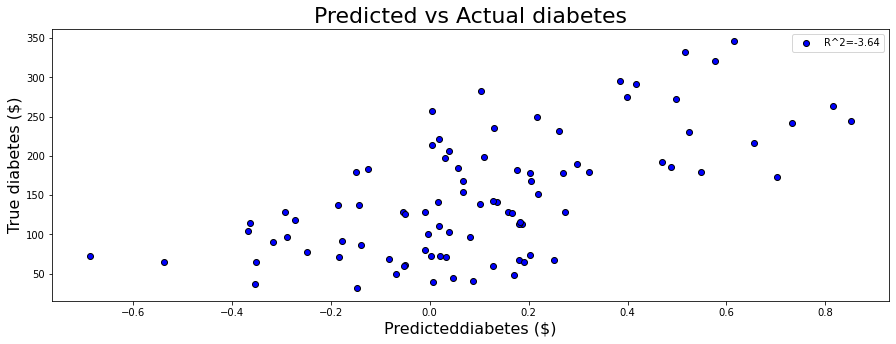

In [65]:
plot_all_observations(y_test, y_pred, y_censor_label)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Warmup:   0%|          | 0/406 [10:18, ?it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

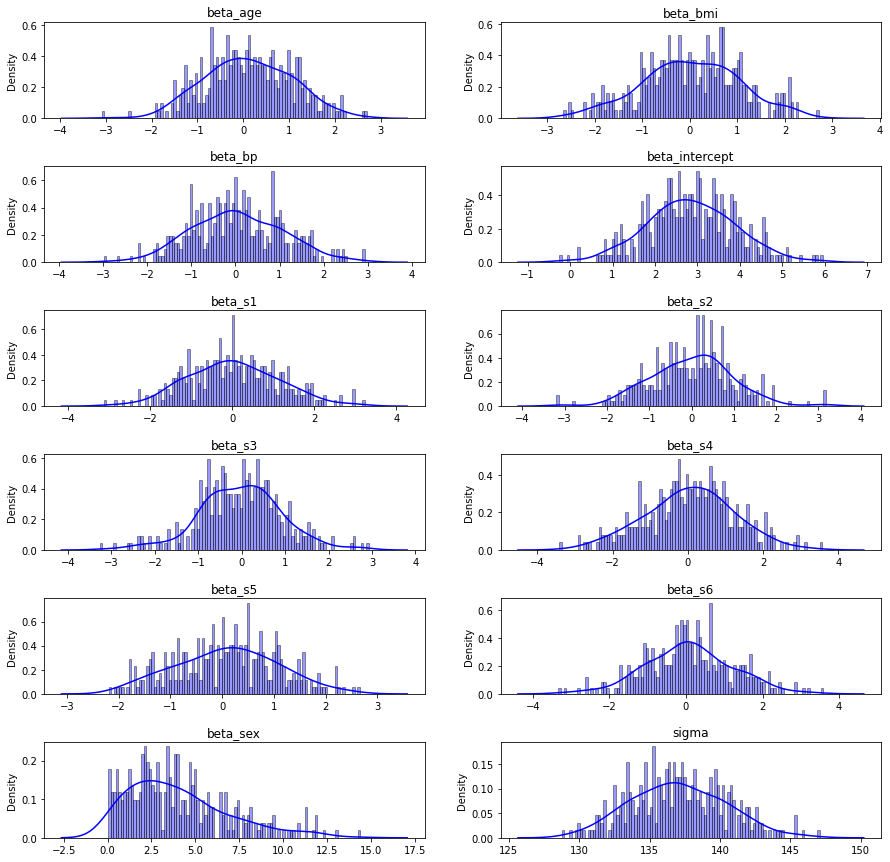

In [66]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(6,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_coefficients(beta_df)